In [1]:
# %load uoicorr_imports.py
import h5py

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from math import floor, ceil

# Script to add the entire project directory structure to the python path
import sys, os

# Hack to import pyuoi
parent_path, current_dir = os.path.split(os.path.abspath('.'))
while current_dir not in ['nse']:
	parent_path, current_dir = os.path.split(parent_path)
p = os.path.join(parent_path, current_dir)
# Add analysis
if p not in sys.path:
	sys.path.append(p)

# And standard list of subdirectories
if '%s\\pyuoi' % p not in sys.path:
	sys.path.append('%s\\pyuoi' % p)

from pyuoi.linear_model.lasso import UoI_Lasso
from pyuoi.linear_model.elasticnet import UoI_ElasticNet
from pyuoi.linear_model.hybrid import UoI_Hybrid

from postprocess import postprocess_file, postprocess_dir

In [2]:
from utils import gen_data, gen_beta, gen_covariance
beta = gen_beta(n_features = 60, block_size = 60, sparsity = 0.4)
covariance = gen_covariance('falloff')
X, X_test, y, y_test = gen_data(300, 60, 0.3, covariance, beta)

In [3]:
uoi = UoI_Hybrid(
    normalize=True,
    n_boots_sel=48,
    n_boots_est=48,
    alphas = [0.1, 0.25, 0.5, 0.9, 0.95, 0.99, 1],
    estimation_score= 'r2',
    warm_start = False
)

In [4]:
uoi.fit(X, y)

UoI_Hybrid(alphas=[0.1, 0.25, 0.5, 0.9, 0.95, 0.99, 1], comm=None,
      copy_X=True, eps=0.001, estimation_frac=0.9, estimation_score='r2',
      fit_intercept=True, max_iter=None, n_boots_est=48, n_boots_sel=48,
      n_lambdas=48, normalize=True, random_state=None, selection_frac=0.9,
      stability_selection=1.0, warm_start=False)

In [5]:
uoi.supports_en_

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True, False,  True]])

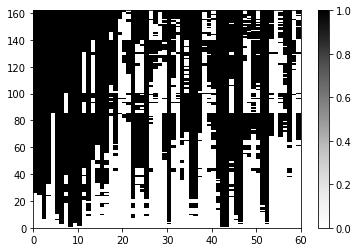

In [8]:
plt.pcolor(1 * uoi.supports_en_, cmap = 'Greys')
plt.colorbar()

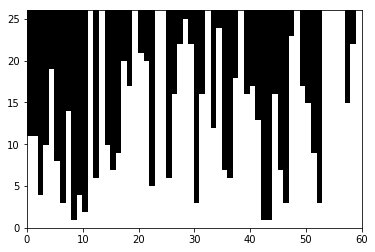

In [10]:
plt.pcolor(1 * uoi.supports_lasso_, cmap = 'Greys')

### Scatter of false positive and false negatives within each model support

In [5]:
fn_en = np.zeros(uoi.supports_en_.shape[0])
fp_en = np.zeros(fn_en.size)

for i in range(fn_en.size):
    fn_en[i] = np.count_nonzero(beta[uoi.supports_en_[i, :] == 0, 0])
    fp_en[i] = np.count_nonzero(uoi.supports_en_[i, :][beta.ravel() == 0])

fn_lasso = np.zeros(uoi.supports_lasso_.shape[0])
fp_lasso = np.zeros(fn_lasso.size)
for i in range(fn_lasso.size):
    fn_lasso[i] = np.count_nonzero(beta[uoi.supports_lasso_[i, :] == 0, 0])
    fp_lasso[i] = np.count_nonzero(uoi.supports_lasso_[i, :][beta.ravel() == 0])

fn_naive = np.zeros(uoi.supports_naive.shape[0])
fp_naive = np.zeros(fn_naive.size)

for i in range(fn_naive.size):
    fn_naive[i] = np.count_nonzero(beta[uoi.supports_naive[i, :] == 0, 0])
    fp_naive[i] = np.count_nonzero(uoi.supports_naive[i, :][beta.ravel() == 0])    

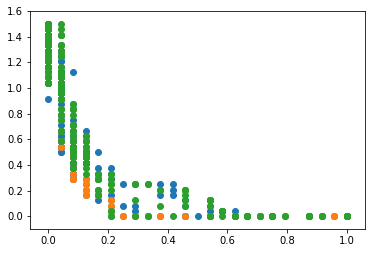

In [6]:
plt.scatter(fn_en/24, fp_en/24)
plt.scatter(fn_lasso/24, fp_lasso/24)
plt.scatter(fn_naive/24, fp_naive/24)